In [1]:
import os
import warnings
from IPython.display import display, HTML
import platform
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time
import random
from PreprocessFcns import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [2]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [3]:
user_id_pairings = pd.read_csv("//FS2.smpp.local/RTO/CIS-PD MUSC\decoded_forms\\videoID.csv")

In [4]:
### SETUP TRAINING DATA (from clicic visits) ###

# get all data and remove useless rows
Xtrain = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesHP_All_subjs.csv',index_col=0)
Xtrain = Xtrain[Xtrain.Subject!=1020]
Xtrain = Xtrain[~Xtrain['Tremor'].isnull()]
Xtrain = Xtrain[~Xtrain['Bradykinesia'].isnull()]
Xtrain = Xtrain.reset_index(drop=True)
# get tremor training target
# indp = ((Xtrain['Tremor']>0))
indp = Xtrain['Tremor']
indp = indp.values
ytrain_tremor = indp.astype(int)
# get bradykinesia training target
# indp = ((Xtrain['Bradykinesia']>0))
indp = Xtrain['Bradykinesia']
indp = indp.values
ytrain_bradykinesia = indp.astype(int)
# get the training data set
Xtrain = Xtrain.iloc[:,5:].as_matrix()

clf_tremor = RandomForestRegressor(n_estimators=100, max_features = 0.5, random_state=2)
clf_tremor.fit(Xtrain, ytrain_tremor)

clf_bradykinesia = RandomForestRegressor(n_estimators=100, max_features = 0.5, random_state=2)
clf_bradykinesia.fit(Xtrain, ytrain_bradykinesia)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


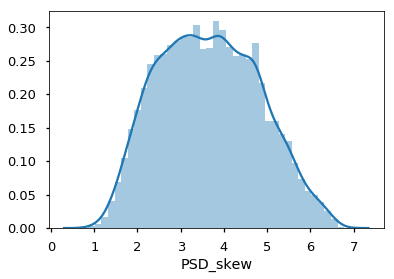

In [17]:
### organize data
task_feature_files = os.listdir('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//')
Data = pd.DataFrame()
for f in task_feature_files:
    # Exclude subjects who did not fit original models for Tremor and Bradykinesia
    # l = ['142561', '142618', '142622', '142612', '142608', '142578', '142563', '142577', '142560', '142585', '142581', '142583', '142593', '142575']
       # Exclude subjects who did not fit original model for Tremor
    # l = ['142622', '142575', '142608', '142585', '142563', '142612', '142561'] #, '142593']  # subj 1020=142561 optional at end
    l = [] # Include all subjects
    if f[:6] not in l:
        if(Data.empty):
            Data = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//' + f)
        else:
            d = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//' + f)
            Data = Data.append(d, ignore_index = True)
Data = Data[~Data['Tremor'].isnull()]
Data = Data[~Data['Bradykinesia'].isnull()]
np.sort(Data.Subject.unique())
# remove 1020
Data=Data[Data.Subject!=1020]
for index, row in Data.iterrows():
    if (row['Visit'] == '4 Weeks'):
        Data.loc[index, 'Visit'] = '1 Month'
Data=Data.reset_index(drop=True)
Dataorig = Data.copy()
tasks = Dataorig['Task'].unique()
subjects = Dataorig['Subject'].unique()
# print(Data.head())
# sanity check
sns.distplot(Data.PSD_skew)

In [18]:
features_for_each_subj = {}

final_features = pd.DataFrame()

for subject in subjects:
    t1=time.time()
    # Training Model
    Data = Dataorig.copy()
    Data=Data.reset_index(drop=True) #reset index
    summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
    
    Data = Data[Data['Subject'] == subject]
    Data=Data.reset_index(drop=True)

    for index, row in Data.iterrows(): 
        try:
            Data.loc[index, 'MDS score'] = int(summary_info.loc[(summary_info.VisitNm == row['Visit']) & (summary_info["SubjectCode"] == row['Subject']), 'MDS_score'])
        except:
            Data.loc[index, 'MDS score'] = float('Nan')
            
        try:
            Data.loc[index, 'baseline MDS'] = int(summary_info.loc[(summary_info.VisitNm == 'Baseline') & (summary_info["SubjectCode"] == row['Subject']), 'MDS_score'])
        except:
            Data.loc[index, 'baseline MDS'] = float('Nan')
        
    #remove nan rows 
    Data=Data[~Data['MDS score'].isnull()]
    Data = Data[~Data['baseline MDS'].isnull()]
    # select only walking related rows
    Data=Data.reset_index(drop=True) #reset index

    if (Data.empty):
        continue
    Xpred = Data.iloc[:,0:-8].as_matrix()

    predicted_tremor = clf_tremor.predict(Xpred)
    predicted_bradykinesia = clf_bradykinesia.predict(Xpred)
                               
    features_for_each_visit = {}
    
    new_features = pd.DataFrame()
    new_features.insert(loc = len(new_features.columns.values), column = 'Visit', value = Data['Visit'])
    new_features.insert(loc = len(new_features.columns.values), column = 'Task', value = Data['Task'])
    new_features.insert(loc = len(new_features.columns.values), column = 'MDS score', value = Data['MDS score'])
    new_features.insert(loc = len(new_features.columns.values), column = 'baseline MDS', value = Data['baseline MDS'])
    new_features.insert(loc = len(new_features.columns.values), column = 'predicted tremor', value = predicted_tremor)
    new_features.insert(loc = len(new_features.columns.values), column = 'predicted bradykinesia', value = predicted_bradykinesia)
    
    visits = Data['Visit'].unique()
    
    for visit in visits:
        features = new_features[new_features['Visit'] == visit]
        MDS = features['MDS score'].mean()
        baseline_MDS = features['baseline MDS'].mean()
        columns = ['Subject', 'Visit', 'MDS score', 'baseline MDS']
        values = [subject, visit, MDS, baseline_MDS]
        for task in tasks:
            task_features = features[features['Task'] == task]
            
            task_mean_t = task_features['predicted tremor'].mean()
            task_var_t = task_features['predicted tremor'].var()
            task_mean_b = task_features['predicted bradykinesia'].mean()
            task_var_b = task_features['predicted bradykinesia'].var()
            columns += [task + ' var tremor', task + ' mean tremor', task + ' var bradykinesia', task + ' mean bradykinesia']
            values += [task_var_t, task_mean_t, task_var_b, task_mean_b]
        final_features = final_features.append(pd.DataFrame(data = [values], columns = columns), ignore_index = True)

final_features = final_features.dropna()
final_features.style

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


,Subject,Visit,MDS score,baseline MDS,Typg var tremor,Typg mean tremor,Typg var bradykinesia,Typg mean bradykinesia,RamI var tremor,RamI mean tremor,RamI var bradykinesia,RamI mean bradykinesia,Wlkg var tremor,Wlkg mean tremor,Wlkg var bradykinesia,Wlkg mean bradykinesia,Sheets var tremor,Sheets mean tremor,Sheets var bradykinesia,Sheets mean bradykinesia,FtnI var tremor,FtnI mean tremor,FtnI var bradykinesia,FtnI mean bradykinesia,Drnkg var tremor,Drnkg mean tremor,Drnkg var bradykinesia,Drnkg mean bradykinesia,Fldg var tremor,Fldg mean tremor,Fldg var bradykinesia,Fldg mean bradykinesia,NtsBts var tremor,NtsBts mean tremor,NtsBts var bradykinesia,NtsBts mean bradykinesia,Drwg var tremor,Drwg mean tremor,Drwg var bradykinesia,Drwg mean bradykinesia,WlkgCnt var tremor,WlkgCnt mean tremor,WlkgCnt var bradykinesia,WlkgCnt mean bradykinesia
0,1016,1 Month,32,20,0.0397457,0.528,0.0329429,1.24,0.00052,0.67,0.0540567,1.16167,0.016772,0.465833,0.0999538,1.23917,0.0253267,0.388667,0.0253286,1.05,0.00963,0.485,0.141737,1.19167,0.056897,0.793333,0.0209538,1.25583,0.0125624,0.407222,0.0599088,1.17833,0.0120629,0.344167,0.0203818,1.28,0.0168527,0.277143,0.0137451,0.972857,0.0134529,0.465625,0.01314,1.3425
1,1016,2 Weeks: Time 0,19,20,0.0474296,0.648125,0.0318783,0.98875,0.000906667,0.826667,0.00475,0.895,0.00354706,0.487059,0.0260309,1.40941,0.0321341,0.415714,0.0514995,1.12071,0.00784,0.38,0.0138,1.22,0.0755341,0.805714,0.0368951,1.22786,0.0216494,0.377273,0.069316,0.957273,0.0244971,0.576,0.0266838,1.20533,0.0163714,0.27,0.0636238,0.843333,0.00668529,0.498333,0.0161977,1.30278
2,1016,2 Weeks: Time 60,21,20,0.0495781,0.597333,0.0219095,1.21333,0.00914667,0.386667,0.0062,1.04,0.00838667,0.495,0.0216296,1.38812,0.0167912,0.468333,0.0782605,1.17389,0.00390667,0.403333,0.11299,1.275,0.0896835,0.567143,0.0595033,1.17429,0.0169461,0.4075,0.0660116,0.983,0.0111543,0.494,0.00746381,1.25933,0.0249764,0.330714,0.026422,0.942857,0.0160706,0.47,0.0247765,1.33667
4,1024,1 Month,19,15,0.0948692,0.742308,0.0294077,1.12923,0.00323,0.475,0.04732,0.93,0.00640958,0.433125,0.0190117,1.34625,0.0164517,0.40375,0.0193983,0.99875,0.00205667,0.438333,0.168697,1.33833,0.00992515,0.468421,0.0595918,1.11158,0.0189758,0.322857,0.0249055,0.711429,0.0155412,0.507857,0.0187363,1.23857,0.00478727,0.185455,0.0306255,0.926364,0.00524958,0.573125,0.0189496,1.26188
5,1032,2 Weeks: Time 0,28,21,0.0811524,0.353333,0.00213143,0.992,0.00877667,0.778333,0.04272,1.01,0.0099359,0.472308,0.0542897,1.30692,0.208481,0.705769,0.0627458,1.30462,0.0183125,0.62375,0.04005,1.2975,0.134411,0.9024,0.046971,1.2572,0.032321,0.3972,0.0636293,1.1428,0.0860171,0.578,0.0417743,1.248,0.0334066,0.327143,0.015594,1.00643,0.0049456,0.510714,0.0313143,1.40714
6,1032,1 Month,26,21,0.0389577,0.420769,0.0110077,1.00923,0.0117333,0.64,0.00662381,0.992857,0.018411,0.505714,0.0119874,0.922143,0.0694171,0.511316,0.0186831,1.30921,0.0098619,0.405714,0.000857143,1.18286,0.0954326,0.667,0.032245,1.2665,0.0235248,0.435946,0.0581896,1.27784,0.0386383,0.51625,0.0128867,1.3925,0.0153,0.24,0.0099141,1.00154,0.00993143,0.522,0.00760667,0.887333
7,1032,2 Weeks: Time 60,12,21,0.0067033,0.235714,0.023422,0.972857,0.00048,0.514,0.01817,1.462,0.00482692,0.415,0.00656703,0.848571,0.0994537,0.545862,0.0305313,1.27207,0.00133,0.574,0.01008,1.124,0.131192,0.947273,0.0469974,0.995455,0.0347214,0.454231,0.054866,1.205,0.182514,0.788462,0.0145744,1.17923,0.120463,0.515833,0.0148629,0.940833,0.00833167,0.43625,0.0104329,0.899375
9,1051,2 Weeks: Time 0,14,9,0.146446,0.73,0.0574401,1.13357,0.0125905,0.582857,0.0153476,0.821429,0.0122353,0.403333,0.0804291,0.949444,0.010572,0.270833,0.0731902,0.924167,0.00954286,0.31,0.00289821,0.52875,0.02616,0.354,0.0543822,0.924,0.0353996,0.355625,0.0490783,0.63375,0.00717582,0.397143,0.0131346,1.325,0.0153238,0.346667,0.0362924,0.999333,0.00852625,0.370625,0.0688129,0.865625
10,1051,1 Month,11,9,0.00969636,0.298182,0.0211873,1.09545,0.00982679,0.56625,0.0029125,0.99375,0.01456,0.24,0.0321363,0.6

In [19]:
a = []
p = []
subjects = final_features['Subject'].unique()

for s in subjects:

    clf_MDS = RandomForestRegressor(n_estimators=200, max_features = 0.3, random_state = 2)
    # Xtrain, Xtest = train_test_split(final_features, test_size=0.3)
    Xtrain = final_features[final_features['Subject'] != s]
    Xtest = final_features[final_features['Subject'] == s]
    ytrain = Xtrain['MDS score']
    ytrain = ytrain.values
    ytrain = ytrain.astype(int)
    Xtrain = Xtrain.iloc[:, 3:].as_matrix()

    clf_MDS.fit(Xtrain, ytrain)

    predictions = clf_MDS.predict(Xtest.iloc[:, 3:].as_matrix())
    p += list(predictions)

    actual = Xtest['MDS score'].values.astype(int)
    a += list(actual)

    predictions = np.array(predictions)
    actual = np.array(actual)

    # mse = float(np.mean((actual - predictions)**2))
    # print(mse)
#     print(predictions)
#     print(actual)
#     print('\n\n\n')

actual = np.array(a)
predictions = np.array(p)
mse = float(np.mean((actual - predictions)**2))
print(mse)

print(np.corrcoef(p, a)[0][1])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\si

94.02548046875
0.19552256590998135


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


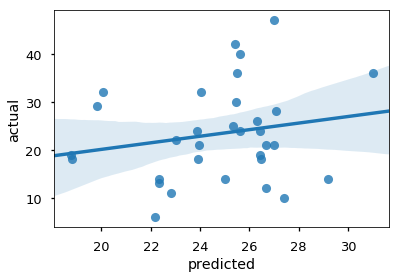

In [20]:
df = pd.DataFrame()
df.insert(loc = len(df.columns.values), column = 'predicted', value = predictions)
df.insert(loc = len(df.columns.values), column = 'actual', value = actual)
sns.regplot(x = 'predicted', y = 'actual', data = df, order = 1)